In [1]:
from theta.rtbm import RTBM
import numpy as np
import matplotlib.pyplot as plt
from theta.minimizer import CMA, SGD
from theta import costfunctions
%matplotlib inline

In [2]:
ndim = 2
nhid = 1
rtbm = RTBM(ndim, nhid, 
            minimization_bound=55, 
            positive_T=True, 
            positive_Q=True,
            gaussian_init=True
           )

def espacio(sample, n=1e5):
    n = int(n)
    u = np.max(sample)
    l = np.min(sample)
    epsilon = np.abs(u)/4.0
    u += epsilon
    l -= epsilon
    r = np.random.rand(ndim, n)
    return l + r*(u-l), pow(u-l, ndim)/n

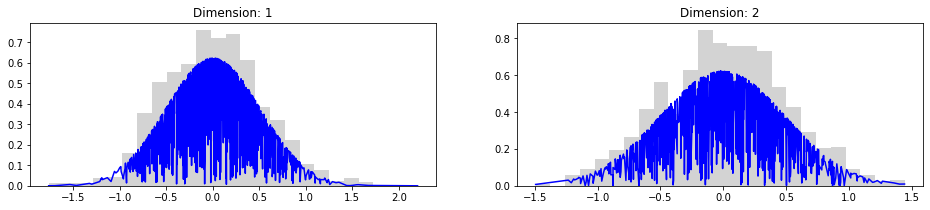

In [3]:
plt.rcParams['figure.figsize'] = [16, 3]

def dome(nevt=1e3, do_rho=True):
    # Sample after gaussian initialization
    nevt = int(nevt)
    xrand, _ = rtbm.make_sample(nevt)
    jac = rtbm(xrand.T)
    
    for d in range(ndim):
        plt.subplot(1,ndim,d+1)
        plt.title(f"Dimension: {d+1}")
        if do_rho:
            x = sorted(xrand[:,d])
            y = [i for _, i in sorted(zip(xrand[:,d], jac[0]))]
            plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
        plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
    plt.show()
    return xrand
xrand = dome()

In [4]:
r, jac = espacio(xrand, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)

1.0016598339875011


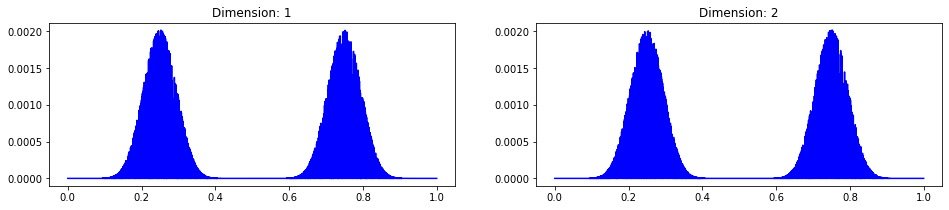

Current mse: 0.07604290923082777
Current KL: 1.700514571427113


In [5]:
# Now train the RTBM to a _different_ functional form
from scipy.special import expit
n = int(1e4)
ff = lambda x: np.prod(np.sin(x*np.pi*2)**12, axis=1)
xvals = np.random.rand(n, ndim)
yvals_raw = ff(xvals)
yvals = yvals_raw/np.sum(yvals_raw)
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals[:,d])
    y = [i for _, i in sorted(zip(xvals[:,d], yvals))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()

current_val = rtbm(xvals.T)[0]
print(f"Current mse: {costfunctions.mse.cost(current_val, yvals)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(current_val, yvals)}")

In [ ]:
from cma import CMAEvolutionStrategy

x0 = rtbm.get_parameters()
bounds = rtbm.get_bounds()

def optimize(n=1):
    sigma = np.min(bounds[1])/(4.0*n)
    es = CMAEvolutionStrategy(x0, sigma, {"bounds":bounds, "maxiter":250})
    # Create a function to be optimized:
    def fun_crate(xin, ytrue, mode = "kl"):
        def objective_fun(params=None):
            if params is not None and not rtbm.set_parameters(params):
                return np.NaN
            prob = rtbm(xin.T)
            if mode == "kl":
                return -np.sum(ytrue*np.log(prob))
            elif mode == "mse":
                return np.sum((prob-ytrue)**2)

        return objective_fun

    target = fun_crate(xvals, yvals, mode="kl")
    es.optimize(target)
    return es.result
    
n = 1
res = optimize(n)
while not rtbm.set_parameters(res.xbest):
    print("Rerunning the optimization, changing sigma")
    n+=1
    optimize(n)    

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=98440, Thu Feb 11 12:56:33 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.782207274482246e+00 1.0e+00 7.20e-01  7e-01  7e-01 0:00.5
    2     20 1.046788740099418e+00 1.2e+00 6.99e-01  7e-01  7e-01 0:00.9
    3     30 1.133773724897964e+00 1.2e+00 8.09e-01  8e-01  9e-01 0:01.3
   10    100 4.166324230003012e-01 1.7e+00 8.01e-01  7e-01  8e-01 0:04.5
   19    190 2.931179862253049e-01 2.0e+00 6.18e-01  4e-01  7e-01 0:08.6
   31    310 2.445868653888186e-01 2.8e+00 4.29e-01  2e-01  5e-01 0:14.1
   45    450 2.215825493418273e-01 3.8e+00 1.51e-01  6e-02  2e-01 0:20.5
   61    610 2.200099937527874e-01 5.7e+00 6.73e-02  2e-02  9e-02 0:27.7
   79    790 2.199760904244537e-01 1.1e+01 2.44e-02  5e-03  4e-02 0:35.8
   99    990 2.199707557645882e-01 2.2e+01 1.01e-02  1e-03  2e-02 0:44.9
  100   1000 2.199710737065790e-01 2.3e+01 9.02e-03  1e-03  2e-02 0:45.4
  125   1250 2.199702973466148e-01 

In [ ]:
new_sample = dome(do_rho=False)
new_pred = rtbm(new_sample.T)[0]
new_y_raw = ff(new_sample)
new_y = new_y_raw/np.sum(new_y_raw)
print(f"Current mse: {costfunctions.mse.cost(new_pred, new_y)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(new_pred, new_y)}")
print("Integral:")
r, jac = espacio(new_sample, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)